In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q ultralytics roboflow pyyaml albumentations


In [ ]:
# 1.2. Import các thư viện Python chính
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import yaml
from roboflow import Roboflow
from IPython.display import Image, display
from ultralytics import YOLO
import torch
import albumentations as A

# 1.3. Tải bộ dữ liệu Fisheye8K từ Roboflow
try:
    rf = Roboflow(api_key="no1ZYfblbLE1rpcBgNOB")
    project = rf.workspace("stubbornstrawsberries").project("fisheye8k")
    version = project.version(7)
    dataset = version.download("yolov11")
    dataset_location = dataset.location
    print(f"✅ Đã tải xong bộ dữ liệu. Vị trí lưu trữ: {dataset_location}")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {e}")
    dataset_location = None

# 1.4. Phân tích và tóm tắt bộ dữ liệu
def summarize_dataset(location):
    """Hàm đọc file data.yaml và thống kê thông tin cơ bản của bộ dữ liệu."""
    print("\n--- Phân tích bộ dữ liệu ---")
    try:
        data_yaml_path = os.path.join(location, 'data.yaml')
        with open(data_yaml_path, 'r') as f:
            data = yaml.safe_load(f)

        num_train = len(os.listdir(os.path.join(location, data['train'].replace('../', ''))))
        num_val = len(os.listdir(os.path.join(location, data['val'].replace('../', ''))))
        num_test = len(os.listdir(os.path.join(location, data['test'].replace('../', ''))))

        print(f"📁 Tên các lớp (Classes): {data['names']}")
        print(f"🔢 Số lượng lớp: {data['nc']}")
        print(f"🖼️ Số lượng ảnh tập Train: {num_train}")
        print(f"🖼️ Số lượng ảnh tập Validation: {num_val}")
        print(f"🖼️ Số lượng ảnh tập Test: {num_test}")
    except Exception as e:
        print(f"❌ Lỗi khi phân tích dataset: {e}")

if dataset_location:
    summarize_dataset(dataset_location)

print("✅ Giai đoạn 1 hoàn tất.")
print("-" * 70)

loading Roboflow workspace...
loading Roboflow project...
✅ Đã tải xong bộ dữ liệu. Vị trí lưu trữ: /content/Fisheye8K-7

--- Phân tích bộ dữ liệu ---
📁 Tên các lớp (Classes): ['0', '1', '2', '3', '4']
🔢 Số lượng lớp: 5
🖼️ Số lượng ảnh tập Train: 3560
🖼️ Số lượng ảnh tập Validation: 506
🖼️ Số lượng ảnh tập Test: 255
✅ Giai đoạn 1 hoàn tất.
----------------------------------------------------------------------


In [ ]:
# ==============================================================================
# GIAI ĐOẠN 2: ĐỊNH NGHĨA CÔNG CỤ TIỀN XỬ LÝ
# ==============================================================================
# In thông báo bắt đầu Giai đoạn 2
print("🚀 Giai đoạn 2: Định nghĩa công cụ tiền xử lý...")

# Hàm kiểm tra tính hợp lệ của ảnh
def check_image_validity(img, img_path=None):
    # Bắt đầu kiểm tra lỗi
    try:
        # Nếu img là None và có img_path, đọc ảnh từ đường dẫn
        if img is None and img_path:
            # Kiểm tra file có tồn tại không
            if not os.path.exists(img_path):
                return False, f"Ảnh không tồn tại: {img_path}"
            # Đọc ảnh bằng OpenCV
            img = cv2.imread(img_path)
            # Kiểm tra nếu không đọc được ảnh
            if img is None:
                return False, f"Không đọc được: {img_path}"
        # Kiểm tra nếu img vẫn là None
        if img is None:
            return False, "Ảnh là None."
        # Kiểm tra định dạng ảnh (2D hoặc 3D)
        if len(img.shape) not in [2, 3]:
            return False, f"Định dạng không hợp lệ: shape {img.shape}"
        # Kiểm tra số kênh màu nếu là ảnh màu
        if len(img.shape) == 3 and img.shape[2] not in [1, 3, 4]:
            return False, f"Kênh màu không hợp lệ: {img.shape[2]}"
        # Kiểm tra nếu ảnh rỗng
        if img.size == 0:
            return False, "Ảnh rỗng"
        # Trả về kết quả hợp lệ
        return True, "Ảnh hợp lệ."
    # Xử lý lỗi nếu có
    except Exception as e:
        return False, f"Lỗi kiểm tra: {str(e)}"

# Hàm phân tích đặc tính ảnh
def analyze_image_properties(img):
    # Bắt đầu phân tích
    try:
        # Chuyển ảnh sang grayscale nếu là ảnh màu
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        # Tính độ sáng trung bình
        mean_brightness = np.mean(gray)
        # Kiểm tra ảnh quá tối
        is_too_dark = mean_brightness < 50
        # Kiểm tra ảnh quá sáng
        is_too_bright = mean_brightness > 200
        # Tính độ mờ bằng Laplacian
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        # Kiểm tra ảnh mờ
        is_blurry = laplacian_var < 100
        # Chuyển ảnh sang không gian màu LAB
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) if len(img.shape) == 3 else cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2LAB)
        # Tách kênh L (độ sáng)
        l, _, _ = cv2.split(lab)
        # Tính độ tương phản
        contrast = np.std(l)
        # Kiểm tra tương phản thấp
        is_low_contrast = contrast < 30
        # Mặc định không có bão hòa thấp
        is_low_saturation = False
        # Nếu là ảnh màu, kiểm tra độ bão hòa
        if len(img.shape) == 3 and img.shape[2] == 3:
            # Chuyển sang không gian màu HSV
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # Tính độ bão hòa trung bình
            saturation = hsv[:, :, 1].mean()
            # Kiểm tra bão hòa thấp
            is_low_saturation = saturation < 50
        # Tạo dictionary chứa gợi ý xử lý
        suggestions = {
            'apply_contrast': is_too_dark or is_too_bright or is_low_contrast,
            'apply_sharpen': is_blurry,
            'apply_augmentation': is_low_saturation or is_low_contrast,
            'issues': []
        }
        # Thêm vấn đề nếu ảnh quá tối
        if is_too_dark:
            suggestions['issues'].append(f"Quá tối (sáng: {mean_brightness:.1f})")
        # Thêm vấn đề nếu ảnh quá sáng
        if is_too_bright:
            suggestions['issues'].append(f"Quá sáng (sáng: {mean_brightness:.1f})")
        # Thêm vấn đề nếu ảnh mờ
        if is_blurry:
            suggestions['issues'].append(f"Mờ (Laplacian: {laplacian_var:.1f})")
        # Thêm vấn đề nếu tương phản thấp
        if is_low_contrast:
            suggestions['issues'].append(f"Tương phản thấp (std: {contrast:.1f})")
        # Thêm vấn đề nếu bão hòa thấp
        if is_low_saturation:
            suggestions['issues'].append(f"Bão hòa thấp (sat: {saturation:.1f})")
        # Trả về gợi ý
        return suggestions
    # Xử lý lỗi nếu có
    except Exception as e:
        return {'issues': [f"Lỗi phân tích: {str(e)}"], 'apply_contrast': False, 'apply_sharpen': False, 'apply_augmentation': False}

# Hàm làm sắc nét ảnh
def sharpen_image(img):
    # Tạo kernel cho bộ lọc làm sắc nét
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    # Áp dụng bộ lọc
    return cv2.filter2D(img, -1, kernel)

# Hàm tải tham số hiệu chỉnh Fisheye
def load_fisheye_params():
    # Định nghĩa ma trận camera K
    K = np.array([[1000, 0, 960], [0, 1000, 540], [0, 0, 1]], dtype=np.float32)
    # Định nghĩa hệ số méo D
    D = np.array([0.1, 0.01, 0.001, 0.0001], dtype=np.float32)
    # Trả về K và D
    return K, D

# Hàm letterbox để resize ảnh mà giữ tỷ lệ
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    # Lấy kích thước gốc của ảnh
    shape = img.shape[:2]
    # Tính tỷ lệ resize
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    # Tính kích thước mới sau resize
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    # Tính padding cần thêm
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]
    # Chia đều padding cho hai bên
    dw /= 2
    dh /= 2
    # Resize ảnh nếu cần
    if shape[::-1] != new_unpad:
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    # Tính vị trí padding
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    # Thêm padding để tạo letterbox
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

# Hàm tăng cường độ tương phản
def enhance_contrast(img):
    # Chuyển ảnh sang không gian màu LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # Tách các kênh L, A, B
    l, a, b = cv2.split(lab)
    # Tạo bộ lọc CLAHE để tăng tương phản
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Áp dụng CLAHE lên kênh L
    cl = clahe.apply(l)
    # Gộp lại các kênh
    limg = cv2.merge((cl, a, b))
    # Chuyển lại sang BGR
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Hàm khử méo Fisheye
def undistort_fisheye(img, K, D):
    # Lấy kích thước ảnh
    h, w = img.shape[:2]
    # Tính ma trận camera mới
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3))
    # Tạo map để khử méo
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
    # Áp dụng map để khử méo
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Hàm tăng cường dữ liệu ảnh (photometric)
def augment_image_photometric(img):
    # Định nghĩa pipeline tăng cường với RandomBrightnessContrast và RandomGamma
    transform = A.Compose([A.RandomBrightnessContrast(p=0.5), A.RandomGamma(p=0.5)])
    # Áp dụng pipeline lên ảnh
    return transform(image=img)['image']

# Hàm pipeline tiền xử lý ảnh tổng hợp
def ultimate_preprocess_pipeline(image_path=None, img=None, is_fisheye=None, K_fisheye=None, D_fisheye=None, fix_contrast=False, apply_augmentation=False, apply_sharpen=False):
    # Kiểm tra tính hợp lệ của ảnh
    is_valid, error_msg = check_image_validity(img, image_path)
    # Nếu không hợp lệ, in lỗi và trả về None
    if not is_valid:
        print(f"❌ Lỗi xử lý: {error_msg}")
        return None
    # Nếu img là None, đọc ảnh từ đường dẫn
    if img is None:
        # Đọc ảnh từ file
        img = cv2.imread(image_path)
    # Sao chép ảnh để xử lý
    processed_img = img.copy()
    # Chuyển ảnh grayscale sang BGR nếu cần
    if len(processed_img.shape) == 2:
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2BGR)
    # Chuyển ảnh BGRA sang BGR nếu có kênh alpha
    elif processed_img.shape[2] == 4:
        processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGRA2BGR)
    # Phân tích đặc tính ảnh
    properties = analyze_image_properties(processed_img)
    # In các vấn đề nếu có
    if properties['issues']:
        print(f"⚠️ Phân tích: {', '.join(properties['issues'])}")
    # Quyết định áp dụng các bước xử lý
    final_fix_contrast = fix_contrast or properties['apply_contrast']
    final_apply_augmentation = apply_augmentation or properties['apply_augmentation']
    final_apply_sharpen = apply_sharpen or properties['apply_sharpen']
    # Áp dụng tăng cường dữ liệu nếu cần
    if final_apply_augmentation:
        processed_img = augment_image_photometric(processed_img)
    # Khử méo Fisheye nếu được yêu cầu
    if is_fisheye and K_fisheye is not None and D_fisheye is not None:
        processed_img = undistort_fisheye(processed_img, K_fisheye, D_fisheye)
    # Tăng tương phản nếu cần
    if final_fix_contrast:
        processed_img = enhance_contrast(processed_img)
    # Làm sắc nét nếu cần
    if final_apply_sharpen:
        processed_img = sharpen_image(processed_img)
    # Áp dụng letterbox để resize ảnh
    return letterbox(processed_img, new_shape=(640, 640))

# In thông báo hoàn tất Giai đoạn 2
print("✅ Giai đoạn 2 hoàn tất.")
# In đường phân cách
print("-" * 70)

🚀 Giai đoạn 2: Định nghĩa công cụ tiền xử lý...
✅ Giai đoạn 2 hoàn tất.
----------------------------------------------------------------------


In [ ]:
input_dir = os.path.join(dataset_location, "train/images")
output_dir = "/content/processed_train_images"

os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.lower().endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)

        processed_img = ultimate_preprocess_pipeline(
            image_path=image_path,
            is_fisheye=True,
            fix_contrast=True,
            apply_augmentation=True,
            apply_sharpen=True
        )

        if processed_img is not None:
            cv2.imwrite(output_path, processed_img)
            print(f"✅ Saved: {output_path}")
        else:
            print(f"⚠️ Skipped: {file}")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
✅ Saved: /content/processed_train_images/camera7_A_39_png.rf.76736f7546666fcfe41eccb8dd925397.jpg
⚠️ Phân tích: Bão hòa thấp (sat: 46.9)
✅ Saved: /content/processed_train_images/camera1_A_317_png.rf.3d22b8e7e6a217a16a29d24f6f2df56d.jpg
✅ Saved: /content/processed_train_images/camera1_A_158_png.rf.c1e9641b25860ff366887c36e0d1547d.jpg
⚠️ Phân tích: Bão hòa thấp (sat: 48.7)
✅ Saved: /content/processed_train_images/camera4_M_96_png.rf.49515902d1fe4c50cf0fd538cbd750ca.jpg
⚠️ Phân tích: Tương phản thấp (std: 24.3), Bão hòa thấp (sat: 0.0)
✅ Saved: /content/processed_train_images/camera4_N_404_png.rf.2bb2dd6e8a1039e5fc7332941c772ac1.jpg
✅ Saved: /content/processed_train_images/camera2_A_252_png.rf.fd58c87cd0cb5d1830962c7faf924c19.jpg
⚠️ Phân tích: Tương phản thấp (std: 23.1), Bão hòa thấp (sat: 0.0)
✅ Saved: /content/processed_train_images/camera4_N_164_png.rf.728c18acd639e8942d60be319f25a0bd.jpg
⚠️ Phân tích: Bão hòa thấp (sat: 28.3)
✅

In [ ]:


%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.5/235.7 GB disk)


In [ ]:
import os
import shutil

# Tạo thư mục label đầu ra
os.makedirs("/content/processed_train_labels", exist_ok=True)

# Lặp qua ảnh đã xử lý để tìm và copy file label tương ứng
for file in os.listdir("/content/processed_train_images"):
    if file.endswith(".jpg") or file.endswith(".png"):
        base = os.path.splitext(file)[0]
        src_label = f"/content/Fisheye8K-7/train/labels/{base}.txt"
        dst_label = f"/content/processed_train_labels/{base}.txt"
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)

In [ ]:
!mkdir -p /content/custom_train/train/images
!mkdir -p /content/custom_train/train/labels

In [ ]:
!mv /content/processed_train_images/* /content/custom_train/train/images/
!mv /content/processed_train_labels/* /content/custom_train/train/labels/

In [ ]:
data_yaml_content = """
train: /content/custom_train/train/images
val: /content/custom_train/train/images

nc: 5
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
"""

with open("/content/custom_train/data.yaml", "w") as f:
    f.write(data_yaml_content)


In [ ]:
!yolo task=detect mode=train \
  model=yolo11m.pt \
  data=/content/custom_train/data.yaml \
  epochs=30 imgsz=640 plots=True \
  name=train_on_processed_train


New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/custom_train/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train_on_processed_train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/runs /content/drive/MyDrive/train_on_processed_train2

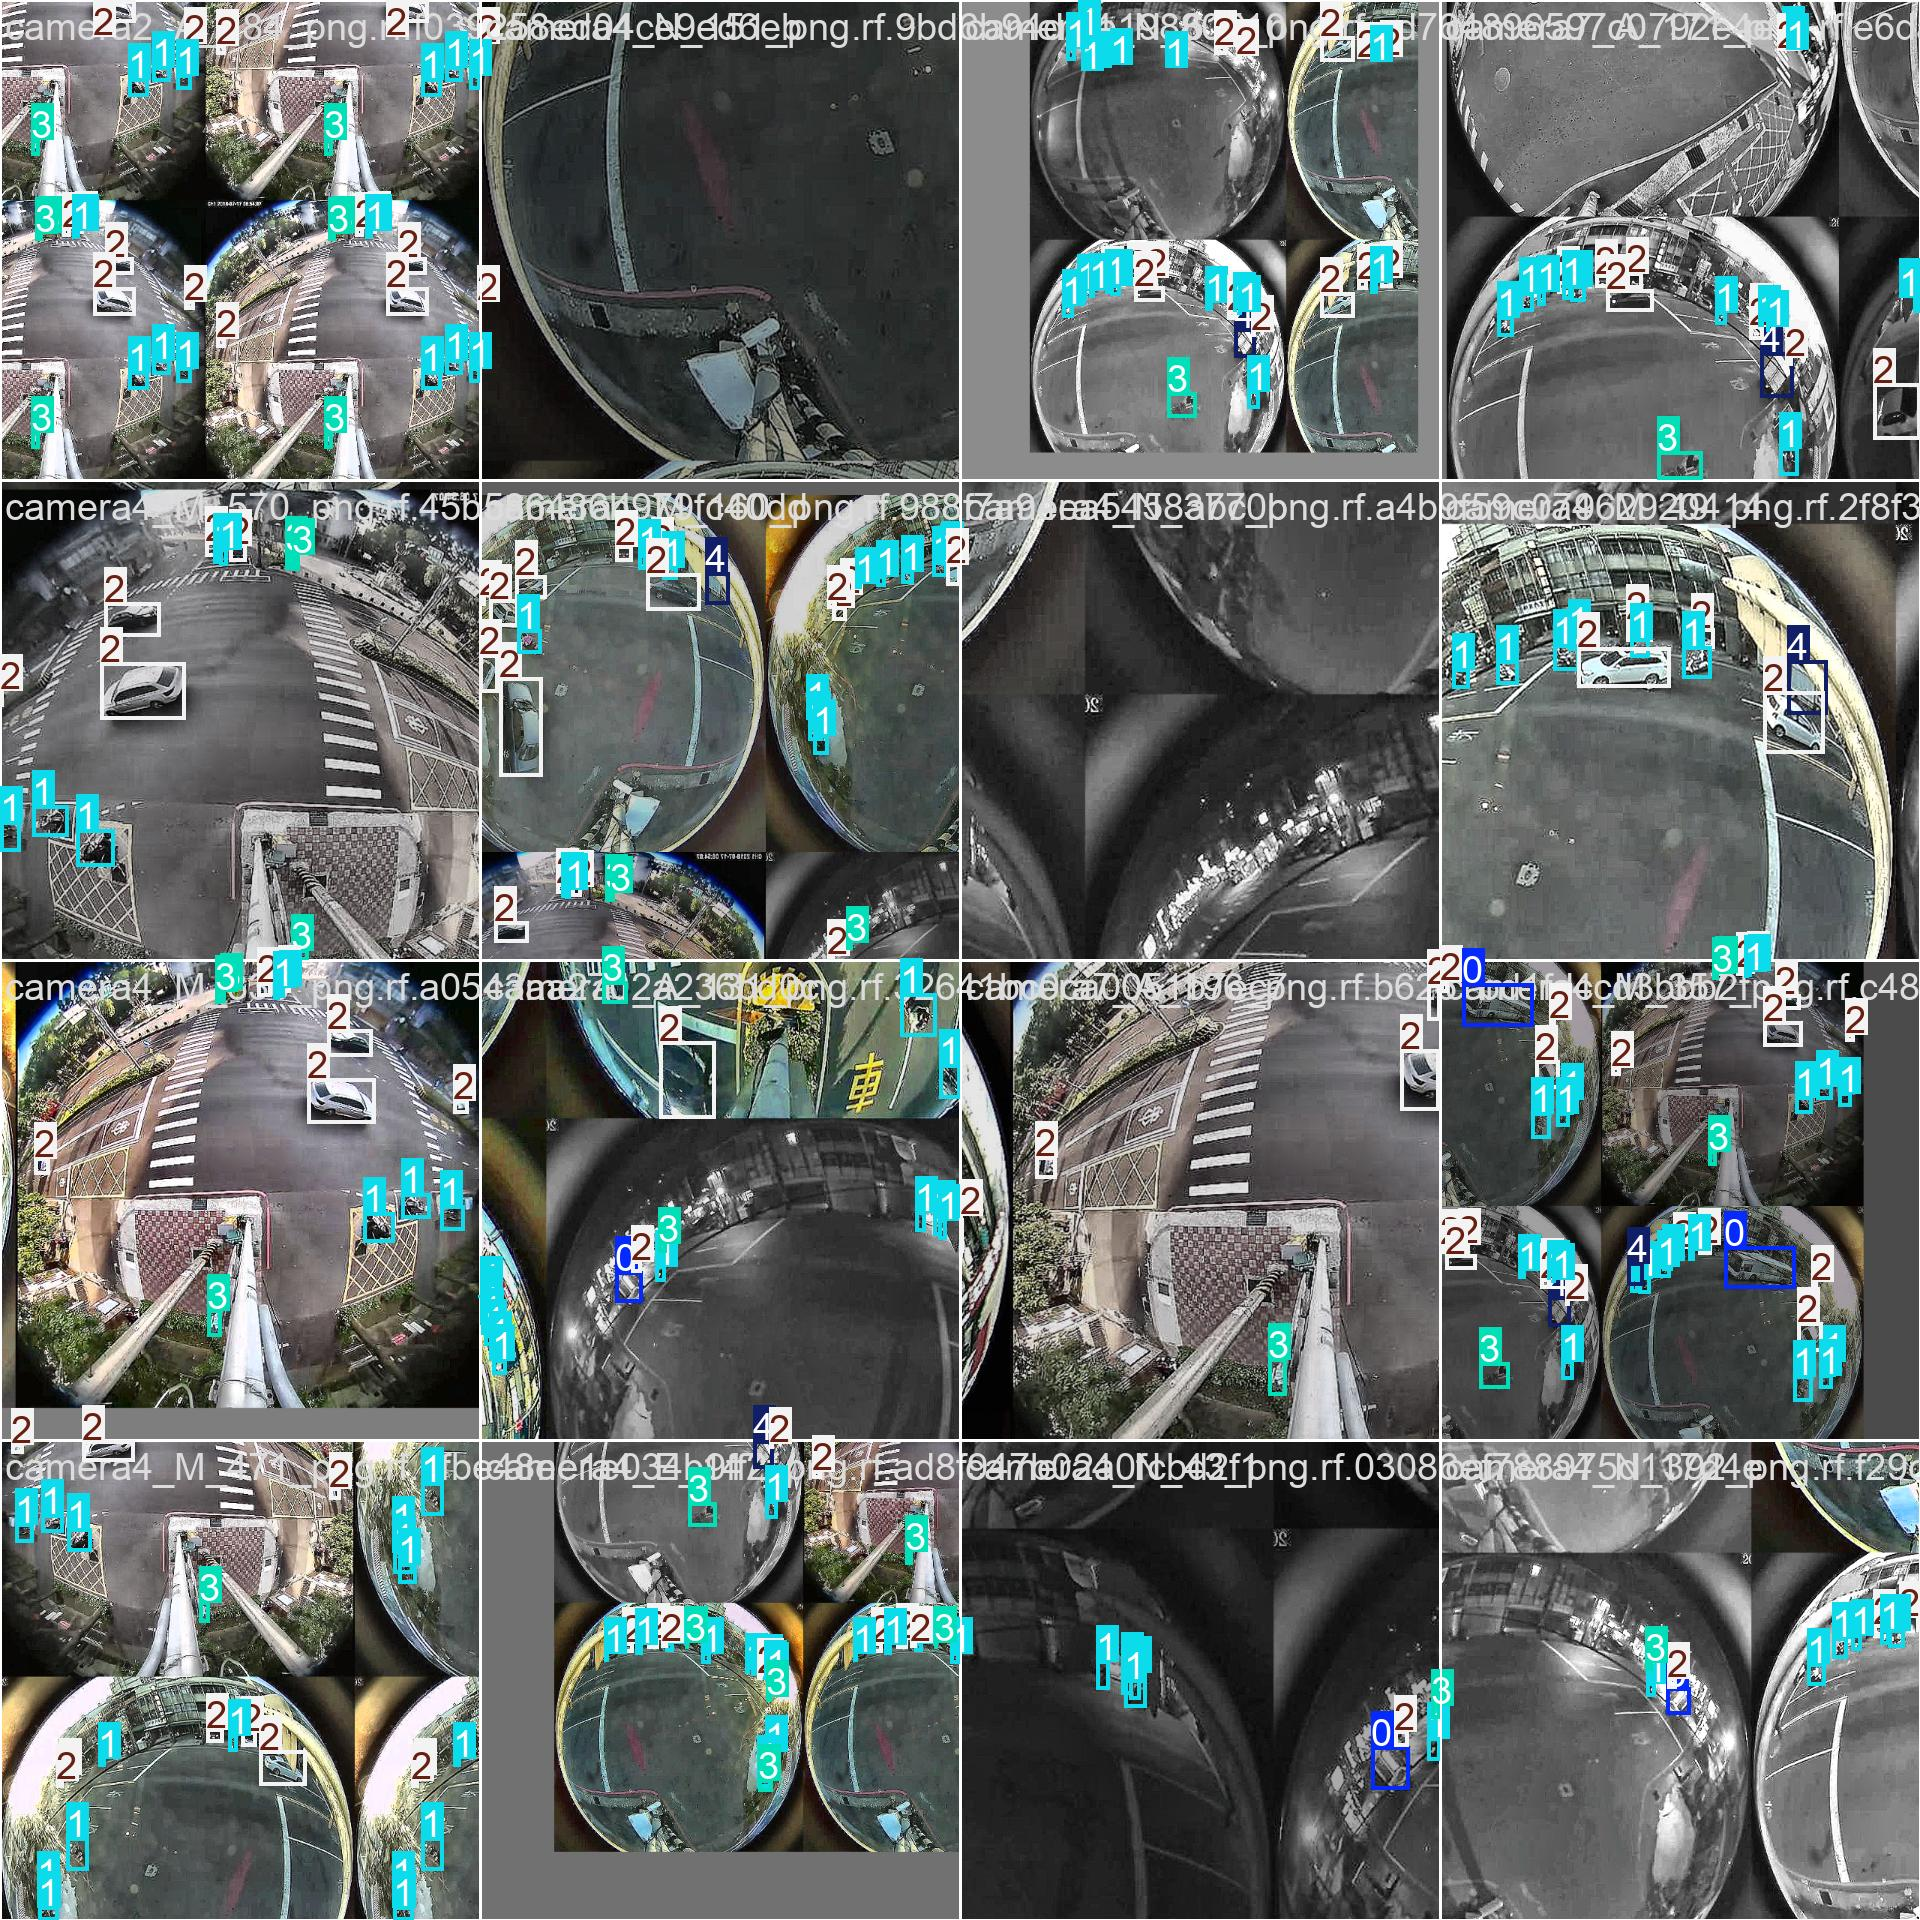

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train_on_processed_train2/train_batch0.jpg', width=600)

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'/content/runs/detect/train_on_processed_train/results.png', width=600)

In [ ]:
from ultralytics import YOLO

# Load model đã train
model = YOLO("/content/runs/detect/train_on_processed_test/weights/best.pt")  # hoặc tên file đúng


In [ ]:
 from google.colab import files
uploaded = files.upload()  # upload ảnh bất kỳ từ máy

# Giả sử bạn upload xong 1 ảnh tên là 'example.jpg'


In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train_on_processed_test/weights/best.pt source=test1.png imgsz=416 save=True
